In [2]:
import tables

In [3]:
import processing_pipeline as pp

path = "Dataset/open-images-v7/train"

current_process = pp.preprocess()
current_process.set_dataframe(path)
current_process.load_data_img(path)
current_process.process_one()
df = current_process.augmentation_process()
#current_process.out_put("/")

INFO:root:Loading labels started...
INFO:root:Dataset labels finished
INFO:root:Loading Images from Dataset/open-images-v7/train started...
INFO:root:1440 Images loaded
INFO:root:Preprocess one started...
INFO:root:Preprocess one finish
INFO:root:Data Augmentation started...
INFO:root:Data Augmentation finished


In [4]:
# Get dataset and label hotdogs
df = current_process.rebuild_dataset()
df['n_label'] = df.label.apply(lambda x: 1 if x=="Hot dog" else 0)

In [5]:
def sample(df, fraction=0.5):
  # Assuming you have a df
  # Randomly sample fraction% of the DataFrame rows without replacement
  sampled_df = df.sample(frac=fraction, replace=False)
  return sampled_df

In [6]:
def hog_features(X_train, X_test):
    import numpy as np
    from skimage.feature import hog

    # Assume you have X train, y train with image
    # Extract HOG features for each image
    hog_features_train = []
    hog_features_test = []

    for image in X_train:
        hog_features = hog(image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
        hog_features_train.append(hog_features)

    for image in X_test:
        hog_features = hog(image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
        hog_features_test.append(hog_features)

    # Convert the features lists to numpy arrays
    X_train_hog = np.array(hog_features_train)
    X_test_hog = np.array(hog_features_test)
    
    return X_train_hog, X_test_hog

In [7]:
def get_raw_pixel_values(X_train, X_test):
  # Raw pixel values
  # You can flatten the image arrays and use the raw pixel values as features. 
  # Each pixel value will be considered as a separate feature. 
  # This approach captures the raw intensity values of each pixel in the image.
  # Assuming your image data is stored in a DataFrame called 'df' with a column named 'image'
  # Convert the image arrays to a numpy array
  # Reshape the images to a 2D array (num_samples, num_pixels)
  num_samples = X_train.shape[0]
  raw_values_train = images.reshape(num_samples, -1)
  
  num_samples = X_test.shape[0]
  raw_values_test = images.reshape(num_samples, -1)
  
  return raw_values_train, raw_values_test

def get_histograms(X_train, X_test):
  import numpy as np
  #Histogram of Pixel Intensities:
  #You can calculate histograms of pixel intensities to capture the distribution of intensity values across the image. 
  # This approach provides information about the overall brightness and contrast of the image.
  # Calculate histograms for each image
  histograms = np.array([np.histogram(image, bins=256, range=(0, 256))[0] for image in X_train])
  # Normalize the histograms
  histogram_train = histograms / histograms.sum(axis=1, keepdims=True)
  
  histograms = np.array([np.histogram(image, bins=256, range=(0, 256))[0] for image in X_test])
  # Normalize the histograms
  histogram_test = histograms / histograms.sum(axis=1, keepdims=True)
  
  return histogram_train, histogram_test

def get_canny_edges(X_train, X_test):
  import cv2
  import numpy as np
  import pandas as pd
  # Apply Canny edge detection to each image
  edges = np.array([cv2.Canny((image*255).astype(np.uint8), threshold1=100, threshold2=200) for image in X_train])
  # Reshape the edge arrays to a 2D array (num_samples, num_pixels)
  num_samples = X_train.shape[0]
  canny_edge_train = edges.reshape(num_samples, -1)
  
  edges = np.array([cv2.Canny((image*255).astype(np.uint8), threshold1=100, threshold2=200) for image in X_test])
  num_samples = X_test.shape[0]
  canny_edge_test = edges.reshape(num_samples, -1)
  
  return canny_edge_train, canny_edge_test

In [8]:
def preprocess_images(X_train, X_test):
  import numpy as np
  from skimage.feature import hog
  from sklearn.preprocessing import StandardScaler
  import pandas as pd

  print('Starting preprocess...')
  print('Getting HOG features...')
  X_train_hog, X_test_hog = hog_features(X_train, X_test)
  print('Getting Histograms...')
  X_train_histogram, X_test_histogram = get_histograms(X_train, X_test)
  print('Getting Canny Edges...')
  X_train_cannyedges, X_test_cannyedges = get_canny_edges(X_train, X_test)
  
  X_train_expanded = pd.concat([pd.DataFrame(X_train_hog), pd.DataFrame(X_train_histogram), pd.DataFrame(X_train_cannyedges)], axis=1)
  X_test_expanded = pd.concat([pd.DataFrame(X_test_hog), pd.DataFrame(X_test_histogram), pd.DataFrame(X_test_cannyedges)], axis=1)
  
  print('Merging & scaling data...')
  # Scale the features
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train_expanded)
  X_test_scaled = scaler.transform(X_test_expanded)
  
  return X_train_scaled, X_test_scaled

In [9]:
def get_predictions(X, y, model):
    import numpy as np
    from skimage.feature import hog
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score
    import pandas as pd
    import time

    # Assuming your image data is stored in a DataFrame called 'df' with a column named 'image'
    # Convert the image arrays to a numpy array
    images = np.array(X.tolist())
    labels = np.array(y)

    # Split the data into training and testing sets
    print('Spliting train/test...')
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    
    X_train_scaled, X_test_scaled = preprocess_images(X_train, X_test)

    print('Training model...')
    # Train the model
    classifier = model
    classifier.fit(X_train_scaled, y_train)
    y_pred_train = classifier.predict(X_train_scaled)

    print('Making predictions...')
    # Make predictions on the test set
    y_pred = classifier.predict(X_test_scaled)

    # Calculate accuracy
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred)
    
    return y_pred_train, y_pred, accuracy_train, accuracy_test


In [10]:
# Test with all preprocess stages
# Get X, y
sampled_df = sample(df, 0.5)

X = sampled_df.img
y = sampled_df.n_label

import time

start = time.time()

# Create model
# Stacking 
from mlxtend.classifier import StackingClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
from sklearn import metrics

m = StackingClassifier(
    classifiers=[
        LogisticRegression(),
        KNeighborsRegressor(n_neighbors=2),
        DecisionTreeClassifier(random_state=0)
    ],
    use_probas=False,
    meta_classifier=LogisticRegression()
)

y_pred_train, y_pred, accuracy_train, accuracy_test = get_predictions(X, y, m)

end = time.time()

print("Total running time in minutes: {}".format((time.time() - start)/60))



Spliting train/test...
Starting preprocess...
Getting HOG features...
Getting Histograms...
Getting Canny Edges...
Merging & scaling data...
Training model...
Making predictions...
Total running time in minutes: 139.23966858386993


In [12]:
accuracy_train

1.0

In [13]:
accuracy_test

0.5642201834862385

In [ ]:
frac_sample = np.arange(0.1, 1.00, 0.05)
accuracy_dict = {'frac':[], 'accuracy':[]}

for frac in frac_sample:
  # Sample df
  sampled_df = sample(df,frac)
  
  # Get X, y
  X = sampled_df.img
  y = sampled_df.n_label
  
  classifier, y_pred, accuracy = get_predictions(X, y)
  accuracy_dict['frac'].append(frac)
  accuracy_dict['accuracy'].append(accuracy)


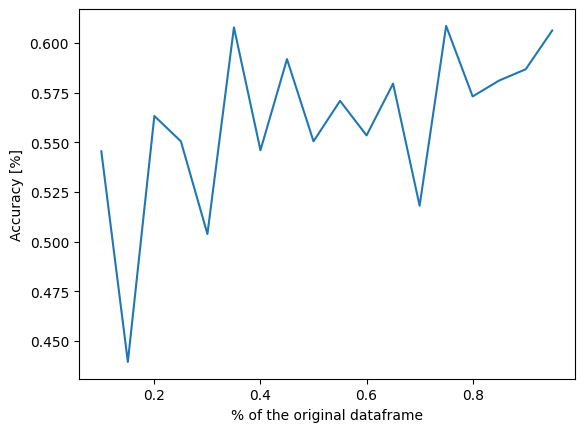

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the dictionary to a DataFrame
accuracy_df = pd.DataFrame.from_dict(accuracy_dict)

# Display the DataFrame

sns.lineplot(data = accuracy_df, x='frac', y='accuracy');
plt.xlabel("% of the original dataframe")
plt.ylabel('Accuracy [%]')
plt.show()


In [ ]:
X_train_scaled.shape

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Define the hyperparameters to be optimized
parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10]
}

# Perform hyperparameter optimization using GridSearchCV
grid_search = GridSearchCV(rf_classifier, parameters, cv=5)
grid_search.fit(X_train, y_train)

# Get the best estimator and its hyperparameters
best_rf_classifier = grid_search.best_estimator_
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_rf_classifier.fit(X_train, y_train)


In [23]:
!pip install --pre pycaret

     |████████████████████████████████| 484 kB 2.6 MB/s eta 0:00:01
  Using cached xxhash-3.2.0-cp39-cp39-macosx_10_9_x86_64.whl (35 kB)
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)
     |████████████████████████████████| 77 kB 5.0 MB/s eta 0:00:011
     |████████████████████████████████| 77 kB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 184 kB/s  eta 0:00:01
  Using cached lightgbm-3.3.5-py3-none-macosx_10_15_x86_64.macosx_11_6_x86_64.macosx_12_0_x86_64.whl (1.3 MB)
     |████████████████████████████████| 72 kB 3.5 MB/s  eta 0:00:01
  Using cached numpy-1.23.5-cp39-cp39-macosx_10_9_x86_64.whl (18.1 MB)
     |████████████████████████████████| 62 kB 6.3 MB/s  eta 0:00:01
     |████████████████████████████████| 17.0 MB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 349 kB/s eta 0:00:01
  Using cached deprecatio

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Define the hyperparameters to be optimized
parameters = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Perform hyperparameter optimization using GridSearchCV
grid_search = GridSearchCV(dt_classifier, parameters, cv=5)
grid_search.fit(X_train, y_train)

# Get the best estimator and its hyperparameters
best_dt_classifier = grid_search.best_estimator_
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_dt_classifier.fit(X_train, y_train)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Create a KNN classifier
knn_classifier = KNeighborsClassifier()

# Define the hyperparameters to be optimized
parameters = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

# Perform hyperparameter optimization using GridSearchCV
grid_search = GridSearchCV(knn_classifier, parameters, cv=5)
grid_search.fit(X_train, y_train)

# Get the best estimator and its hyperparameters
best_knn_classifier = grid_search.best_estimator_
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_knn_classifier.fit(X_train, y_train)


In [9]:
# CNN

import torch
import numpy as np

# Convert each element in the Pandas Series to a NumPy array
arrays = [np.array(x) for x in X_train]
# Stack the NumPy arrays together to create a NumPy array with consistent shapes
array = np.stack(arrays)
# Convert the NumPy array to a PyTorch tensor
tensor_X_train = torch.from_numpy(array)

# Convert each element in the Pandas Series to a NumPy array
arrays = [np.array(x) for x in y_train]
# Stack the NumPy arrays together to create a NumPy array with consistent shapes
array = np.stack(arrays)
# Convert the NumPy array to a PyTorch tensor
tensor_y_train = torch.from_numpy(array)

# Convert each element in the Pandas Series to a NumPy array
arrays = [np.array(x) for x in X_test]
# Stack the NumPy arrays together to create a NumPy array with consistent shapes
array = np.stack(arrays)
# Convert the NumPy array to a PyTorch tensor
tensor_X_test = torch.from_numpy(array)

# Convert each element in the Pandas Series to a NumPy array
arrays = [np.array(x) for x in y_test]
# Stack the NumPy arrays together to create a NumPy array with consistent shapes
array = np.stack(arrays)
# Convert the NumPy array to a PyTorch tensor
tensor_y_test = torch.from_numpy(array)



In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

img_size = 600

# Define the CNN model architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Update input channels to 1
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * (img_size // 4) * (img_size // 4), 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Create an instance of the CNN model
model = CNN()

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert your dataset to PyTorch tensors and dataloaders
# Assuming you have preprocessed tensors X_train, y_train, X_test, y_test

train_dataset = torch.utils.data.TensorDataset(tensor_X_train.float(), tensor_y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(tensor_X_test.float(), tensor_y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train the model
for epoch in range(10):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(1)  # Add extra dimension for grayscale channel
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1} - Loss: {running_loss / len(train_loader)}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(1)  # Add extra dimension for grayscale channel
        outputs = model(inputs)
        predicted = (outputs >= 0.5).squeeze().long()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f"Test Accuracy: {accuracy}")


Epoch 1 - Loss: 49.20992986505682
Epoch 2 - Loss: 49.84848487160423
Epoch 3 - Loss: 50.132575711337005


: 

: 